In [761]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

# Find scripts
sys.path.insert(0, "../src/")
from cda_scripts import *

np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [762]:
# Load data
data_path = Path("../", "data")
df_raw_realized = pd.read_excel(Path(data_path,  "Realized_Schedule_20210101-20220228.xlsx"))
df_raw_future = pd.read_excel(Path(data_path, "Future_Schedule_20220301-20220331.xlsx"))

# String conversion
cat_cols = ["FlightNumber", "Destination", "Airline", "Sector", "FlightType", "AircraftType"]
df_raw_realized[cat_cols] = df_raw_realized[cat_cols].astype(str)
df_raw_future[cat_cols] = df_raw_future[cat_cols].astype(str)

In [822]:
# Model for handling data
class DataModel():
    """
    Class for loading, processing and training ML models on Daylio exported CSV file
    """
    def __init__(self, df_raw, verbose=1):
        self.start_time = "2021-01-01"
        self.time_col = "ScheduleTime"

        self.df_raw = df_raw
        self.df_proc = None
        self.verbose = verbose

        self.X_train = None
        self.y_train = None

        self.X_valid = None
        self.y_valid = None

    def preprocess(self, cat_cols):
        df_proc = self.df_raw.copy()
        print(f"df_raw.shape: {df_proc.shape}")
        print(df_proc.columns)

        #exclude_time = "2021-02-01"
        #df_proc = filter_exclude_time(df_proc, time_col="ScheduleTime", exclude_time=exclude_time)

        # Add counts for flight and capacity monthly
        df_proc = add_flight_counts(df_proc)

        # Add feature how close to ending date range 0-1 (1 is end date)
        df_proc = add_time_delta(df_proc, start_time=self.start_time, time_col=self.time_col)

        # Create one-hot encoded time features
        df_proc = add_date_features(df_proc, self.time_col)

        # One-hot encode other features
        cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType", "FlightNumber"]
        df_proc = map_cat_as_numerical(df_proc, cat_cols, target_col="LoadFactor")

        # Exclude columns
        #exclude_cols = ["Airline", "FlightNumber"]
        #df_proc = remove_columns(df_proc, exclude_cols)

        # Normalize
        #norm_cols = ["SeatCapacity"]
        #df_proc = normalize_minmax_cols(df_proc, norm_cols)

        self.df_proc = df_proc
        print(f"df_proc.shape: {df_proc.shape}")
        print(df_proc.columns)

    def get_trainval(self, val_months, val_years):
        
        X_train, y_train, X_val, y_val = create_trainval(self.df_proc, val_months, val_years)

        return X_train, y_train, X_val, y_val


In [831]:
df_raw = df_raw_realized.copy()
datamodel = DataModel(df_raw)

cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType"]
datamodel.preprocess(cat_cols)

val_months = [11]
val_years = [2021]
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_years)
X_train

df_raw.shape: (39449, 9)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor'],
      dtype='object')
df_proc.shape: (39449, 20)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor',
       'FlightCount_week', 'SectorCount_week', 'AirlineCount_week',
       'FlightCount_month', 'SectorCount_month', 'AirlineCount_month',
       't_delta', 't_dayofyear', 't_dayofmonth', 't_dayofweek', 't_timeofday'],
      dtype='object')


,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,FlightCount_week,SectorCount_week,AirlineCount_week,FlightCount_month,SectorCount_month,AirlineCount_month,t_delta,t_dayofyear,t_dayofmonth,t_dayofweek,t_timeofday
0,0.121046,0.185180,0.082426,-0.002625,-0.247793,-0.002552,142,2.0,67.0,10.0,18.0,510.0,75.0,0.000684,1,1,4,6.583333
1,0.052068,-0.108274,0.001456,-0.112921,-0.247793,0.017179,74,4.0,65.0,4.0,20.0,428.0,20.0,0.006160,1,1,4,10.583333
2,0.121046,0.153066,0.082426,-0.002625,-0.247793,-0.002552,142,3.0,67.0,10.0,19.0,510.0,75.0,0.008214,1,1,4,12.083333
3,0.029052,0.025634,0.034503,-0.112921,-0.247793,-0.002552,72,1.0,67.0,8.0,4.0,510.0,108.0,0.009925,1,1,4,13.333333
4,0.158585,0.160692,0.082426,0.143597,-0.247793,-0.002552,186,2.0,67.0,18.0,2.0,510.0,57.0,0.011294,1,1,4,14.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,0.167526,-0.155540,0.106684,0.111669,-0.247793,0.017179,144,2.0,85.0,11.0,46.0,1896.0,184.0,13.914956,59,28,0,18.750000
39445,0.158585,0.008592,0.097443,0.111669,-0.247793,0.017179,156,1.0,85.0,22.0,35.0,1896.0,440.0,13.915869,59,28,0,19.416667
39446,0.167526,0.142598,0.190955,0.148225,-0.247793,-0.002552,98,1.0,59.0,11.0,11.0,1599.0,184.0,13.916667,59,28,0,20.000000
39447,0.158585,0.191842,0.185986,-0.083220,-0.247793,-0.002552,186,1.0,59.0,22.0,7.0,1599.0,440.0,13.915983,59,28,0,19.500000


In [868]:
val_months = [2]
val_year = [2022]
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_year)

filter_list = ["t_dayof"]
filter_list = ["t_month", "t_year"]
filter_list = ["AirlineCount", "SectorCount"] #18
filter_list = ["Count_month"] # remove month 179,  remove week 181, remove both 180 for feb
# include all 158, remove both 143 for jan, remove count_week 154
# Remove Count_week 
filter_list = ["AirlineCount", "SectorCount", "Count_month"] # Remove airline, sector 0.149
# Remove airline, sector, month count 0.144
# Remove airline, sector, week count 0.148
# filter_list = []
X_train, y_train, X_val, y_val = filter_features(X_train, y_train, X_val, y_val, filter_list)

# Params
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

#print("Lasso")
#model = Lasso()
#model = fit_model(model, X_train, y_train, X_val, y_val)

print("RF")
f = 0.50
max_features = int(len(X_train.columns) * f)
model = RandomForestRegressor(max_features=max_features, random_state=0)
model = fit_model(model, X_train, y_train, X_val, y_val)

RF
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.178, MSE: 0.05, Pearson 0.763, Acc: 0.822


In [857]:
X_train

,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,t_delta,t_dayofyear,t_dayofmonth,t_dayofweek,t_timeofday
0,0.121046,0.185180,0.082426,-0.002625,-0.247793,-0.002552,142,0.000684,1,1,4,6.583333
1,0.052068,-0.108274,0.001456,-0.112921,-0.247793,0.017179,74,0.006160,1,1,4,10.583333
2,0.121046,0.153066,0.082426,-0.002625,-0.247793,-0.002552,142,0.008214,1,1,4,12.083333
3,0.029052,0.025634,0.034503,-0.112921,-0.247793,-0.002552,72,0.009925,1,1,4,13.333333
4,0.158585,0.160692,0.082426,0.143597,-0.247793,-0.002552,186,0.011294,1,1,4,14.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
36486,0.167526,0.185886,0.190955,0.148225,-0.247793,-0.002552,98,12.993308,31,31,0,17.500000
36487,0.158585,0.216966,0.200535,0.111669,-0.247793,0.017179,156,12.992966,31,31,0,17.250000
36488,0.077945,0.169127,0.109075,0.081696,-0.247793,-0.002552,189,12.994107,31,31,0,18.083333
36489,0.158585,0.142684,0.184299,0.111669,-0.247793,0.017179,156,12.995019,31,31,0,18.750000


/Users/maghoi/opt/anaconda3/envs/py39/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Text(0.5, 0, 'Feature importance')

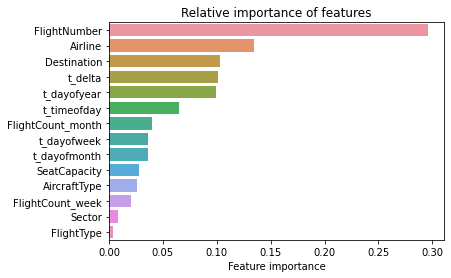

In [844]:
coef = get_coef(model, X_train)

features = ["FlightCount", "MonthCapacity","t_delta", "FlightNumber", "SeatCapacity",
            "t_", "Aircraft_", "Destination_", "Airline_",
            "FlightType_", "Sector_", "SectorCount"]

features = X_train.columns
S = pd.Series(index=features)
for f in features:
    m = coef.index.str.contains(f)
    imp = np.round(coef[m].sort_values()[::-1].sum(), 3)
    S.loc[f] = imp

S_importance = S.sort_values()[::-1]

sns.barplot(x=S_importance.values, y=S_importance.index)
plt.title("Relative importance of features")
plt.xlabel("Feature importance")


Text(0.5, 0, 'Feature importance')

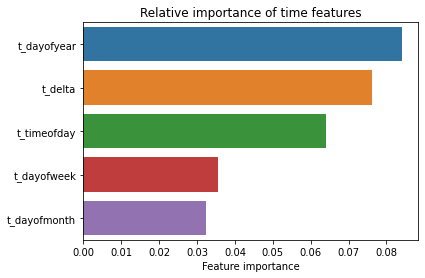

In [836]:
coef = get_coef(model, X_train)
m = coef.index.str.contains("^t_")
time = coef[m].sort_values()[::-1]
sns.barplot(x=time.values, y=time.index)
plt.title("Relative importance of time features")
plt.xlabel("Feature importance")

In [563]:
# analyze top features
exclude_cols = ["Aircraft", "Destination", "Airline"]
exclude_cols = []
print("top:\n", get_top_coef_perc(model, X_train, exclude_cols))
print("all:\n", get_coef(model, X_train))

top:
 Destination     0.269125
AircraftType    0.143658
t_time          0.143321
t_delta         0.117851
SeatCapacity    0.102017
FlightCount     0.100285
t_day           0.088530
Sector          0.013543
FlightType      0.011354
SectorCount     0.010316
dtype: float64
all:
 Destination     0.269125
AircraftType    0.143658
FlightType      0.011354
Sector          0.013543
SeatCapacity    0.102017
FlightCount     0.100285
SectorCount     0.010316
t_delta         0.117851
t_year_2021     0.000000
t_year_2022     0.000000
t_month         0.000000
t_day           0.088530
t_time          0.143321
dtype: float64


In [ ]:
# Filter to subset features top n
top_n_features=500
top_features = get_coef(model, X_train).index[:top_n_features]
print(len(top_features))

X_train2, y_train2, X_val2, y_val2 = select_features(X_train, y_train, X_val, y_val, top_features)
f = 0.25
max_features = int(len(X_train2.columns) * f)
model2 = RandomForestRegressor(max_features=f, max_samples=0.70,
                                min_samples_leaf=1, min_samples_split=8)
model2 = fit_model(model2, X_train2, y_train2, X_val2, y_val2)

427
Train: MAE: 0.092, Pearson 0.897
Valid: MAE: 0.188, Pearson 0.584
Filtered feature importance 100.0 %


In [ ]:
top_n_features=20
exclude_features = get_coef(model, X_train).index[top_n_features:]

Index(['SeatCapacity', 'time_delta', 'year_2021', 'year_2022', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'dayofweek_7', 'day', 'month', 'is_month_start',
       'is_month_end', 'is_year_start', 'is_year_end', 'is_quarter_start',
       'is_quarter_end', 'Destination_AFW'],
      dtype='object')

In [ ]:
val_months = [11]
val_year = "year_2021"
exclude_cols = ["ScheduleTime"]
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_year, exclude_cols)

import sklearn.linear_model as linear_model
model = linear_model.Lasso(alpha=1e-04)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
test_performance_continuous(y_pred_train, y_train, text="Train:")

y_pred_val = model.predict(X_val)
test_performance_continuous(y_pred_val, y_val, text="Valid:")

exclude_cols = ["Aircraft", "Destination", "Airline"]
exclude_cols = []
get_top_coef_perc(model, X_train, exclude_cols)

Excluding cols in features: ['LoadFactor', 'ScheduleTime']
Train: MAE: 0.132, Pearson 0.758
Valid: MAE: 0.193, Pearson 0.553


AttributeError: 'Lasso' object has no attribute 'coef'

Filtered feature importance 100.0 %


Airline_SH         2.590680e-02
Destination_DAB    2.368636e-02
Destination_YXE    2.324802e-02
Destination_YJO    2.009667e-02
Destination_RKS    1.834233e-02
                       ...     
Destination_YXH    5.060439e-05
day                4.908134e-05
Destination_DOH    2.984629e-05
Airline_OF         1.775769e-05
Sector_EG          3.817405e-07
Length: 173, dtype: float64